In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.files import results_dir
from src.iaf.source_population import SourcePopulationGabor
from src.plotting import errorPlot
from src.iaf.analysis import (
    gather_metadata,
    gather_results,
    gather_rates,
    gather_weights,
    get_groupnames,
    sort_orientation_preference,
)

In [2]:
experiment_folder = results_dir("iaf_runs") / "hofer" / "20250320"
metadata = gather_metadata(experiment_folder, experiment_type="hofer")
firing_rates = gather_rates(metadata, experiment_type="hofer")
weights = gather_weights(metadata, experiment_type="hofer", average_method="fraction", average_window=0.2, normalize=True)

In [3]:
results = gather_results(metadata)

In [8]:
orientation_preference = {sg: np.argmax(weights[sg], axis=-1) % 4 for sg in get_groupnames()}
weights_preferred = sort_orientation_preference(weights, orientation_preference["proximal"])

In [74]:
def summarize_weights(weights, orientation_preference):
    meta_shape = orientation_preference.shape
    num_meta = np.prod(meta_shape)
    group_names = get_groupnames()
    weight_groups = [
        "central-preferred",
        "central-other",
        "edge-preferred",
        "edge-other",
        "outer-preferred",
        "outer-other",
    ]
    weight_summary = {weight_group: np.full((num_meta, len(group_names)), np.nan) for weight_group in weight_groups}
    
    central_idx = 4
    orientation_preference = orientation_preference.reshape(-1)
    for isg, sg in enumerate(group_names):
        sgweights = weights[sg].reshape(-1, 9, 4)
        for iexperiment in range(num_meta):
            # Total weight in central position for preferred / other orientations
            central_preferred = sgweights[iexperiment, central_idx, orientation_preference[iexperiment]]
            central_other = np.sum(sgweights[iexperiment, central_idx]) - central_preferred
            # Get indices to edge positions for this orientation preference
            edge0, edge1 = SourcePopulationGabor.stimulus_to_edge_positions(orientation_preference[iexperiment], flattened=True)
            # Measure edge weights for preferred / other orientations
            preferred0 = sgweights[iexperiment, edge0, orientation_preference[iexperiment]]
            preferred1 = sgweights[iexperiment, edge1, orientation_preference[iexperiment]]
            other0 = np.sum(sgweights[iexperiment, edge0]) - preferred0
            other1 = np.sum(sgweights[iexperiment, edge1]) - preferred1
            # Total weight in all positions for preferred / other orientations
            total_preferred = np.sum(sgweights[iexperiment, :, orientation_preference[iexperiment]])
            total_other = np.sum(sgweights[iexperiment]) - total_preferred
            # Fill up summary matrix
            weight_summary["central-preferred"][iexperiment, isg] = central_preferred
            weight_summary["central-other"][iexperiment, isg] = central_other
            weight_summary["edge-preferred"][iexperiment, isg] = preferred0 + preferred1
            weight_summary["edge-other"][iexperiment, isg] = other0 + other1
            weight_summary["outer-preferred"][iexperiment, isg] = total_preferred - central_preferred - preferred0 - preferred1
            weight_summary["outer-other"][iexperiment, isg] = total_other - central_other - other0 - other1

    for weight_group in weight_groups:
        weight_summary[weight_group] = np.reshape(weight_summary[weight_group], (*meta_shape, 3))
        
    return weight_summary

summary = summarize_weights(weights, orientation_preference["proximal"])

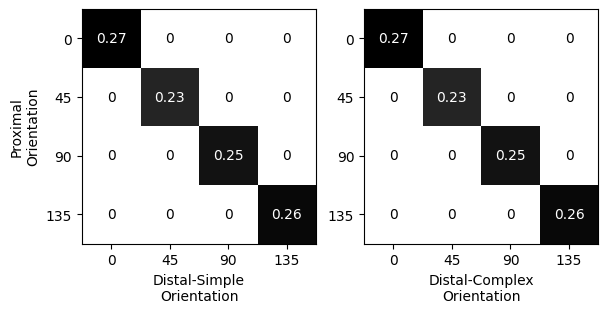

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")
ConfusionMatrixDisplay.from_predictions(orientation_preference["distal-simple"].reshape(-1), orientation_preference["proximal"].reshape(-1), ax=ax[0], cmap="gray_r", colorbar=False, normalize="all")
ConfusionMatrixDisplay.from_predictions(orientation_preference["distal-complex"].reshape(-1), orientation_preference["proximal"].reshape(-1), ax=ax[1], cmap="gray_r", colorbar=False, normalize="all")
ax[0].set_xlabel("Distal-Simple\nOrientation")
ax[1].set_xlabel("Distal-Complex\nOrientation")
ax[0].set_ylabel("Proximal\nOrientation")
ax[1].set_ylabel(None)
ticks = np.arange(4)
labels = np.array(ticks * 180 / 4, dtype=int)
ax[0].set_xticks(ticks, labels)
ax[1].set_xticks(ticks, labels)
ax[0].set_yticks(ticks, labels)
ax[1].set_yticks(ticks, labels)
plt.show()

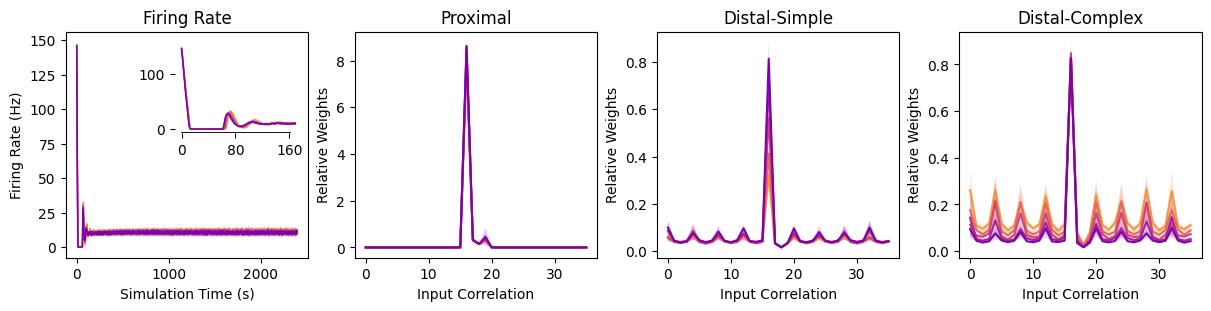

In [5]:
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]
num_inputs = SourcePopulationGabor.num_inputs

fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
inset = ax[0].inset_axes([0.45, 0.55, 0.5, 0.4])
iedge = 1
for iratio in range(num_ratios):
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio, iedge], axis=1), axis=0, ax=ax[0], color=colors[iratio], linewidth=1.0)
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio, iedge], axis=1), axis=0, ax=inset, color=colors[iratio], linewidth=1.0)
    proximal_mean = np.mean(weights_preferred["proximal"][iratio, iedge], axis=1)  
    distal_simple_mean = np.mean(weights_preferred["distal-simple"][iratio, iedge], axis=1)
    distal_complex_mean = np.mean(weights_preferred["distal-complex"][iratio, iedge], axis=1)
    errorPlot(range(num_inputs), proximal_mean, axis=0, ax=ax[1], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(range(num_inputs), distal_simple_mean, axis=0, ax=ax[2], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(range(num_inputs), distal_complex_mean, axis=0, ax=ax[3], color=colors[iratio], alpha=0.2, linewidth=1.5)
ylim0 = ax[0].get_ylim()
inset.set_xlim(-10, 170)
inset.set_xticks([0, 80, 160])
inset.spines["top"].set_visible(False)
inset.spines["right"].set_visible(False)
inset.spines["left"].set_visible(False)
inset.spines["bottom"].set_visible(False)
inset.plot([0, 160], [ylim0[0], ylim0[0]], color="k", linewidth=2.0)
inset.set_ylim(ylim0)
ax[0].set_xlabel("Simulation Time (s)")
ax[0].set_ylabel("Firing Rate (Hz)")
ax[0].set_title("Firing Rate")
for axx, name in zip(ax[1:], ["Proximal", "Distal-Simple", "Distal-Complex"]):
    axx.set_xlabel("Input Correlation")
    axx.set_ylabel("Relative Weights")
    axx.set_title(name)
plt.show()

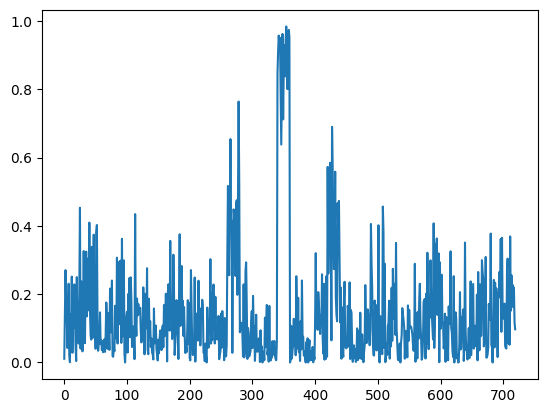

In [30]:
target = "distal-complex"
max_weight = results[0]["sim"].neurons[0].synapse_groups[target].max_weight
plt.plot(results[0]["sim"].neurons[0].synapse_groups[target].weights / max_weight)
plt.show()